In [1]:
# Helper functions
def remove_escape_characters(text: str) -> str:
    return text.replace("\n", " ").replace("·", "")

In [2]:
# Read resumes
import os
from langchain_community.document_loaders import PyPDFLoader

resume_folder_path = "../data/resumes"

# Step 1: Read documents
resume_docs = []
for filename in os.listdir(resume_folder_path):
    if filename.endswith("pdf"):
        filepath = os.path.join(resume_folder_path, filename)
        loader = PyPDFLoader(filepath)
        async for page in loader.alazy_load():
            page.page_content = remove_escape_characters(page.page_content)
            resume_docs.append(page)

In [3]:
# Read job description
jd_file_path = "../data/jd-accounts-specialist.pdf"

jd_docs = []
loader = PyPDFLoader(jd_file_path)
async for page in loader.alazy_load():
    page.page_content = remove_escape_characters(page.page_content)
    jd_docs.append(page)

jd_docs

[Document(metadata={'source': '../data/jd-accounts-specialist.pdf', 'page': 0}, page_content="Job brief   We are looking for an Accounts Payable Specialist to join our team and work with our accounting  department to oversee our organization's expenses.    Accounts Payable Specialist responsibilities include processing payments, verifying invoices and  performing account reconciliations as needed.    Ultimately, you will work with our accounting team to ensure our organization's expenditures are accurate  and our accounting practices are standardized across the organization.   Responsibilities    Charge expenses to accounts and cost centers and control petty cash spending    Verify vendor accounts, pay vendors and resolve purchase order, invoice or payment discrepancies    Issue purchase order amendments and stop payments    Monitor payroll expense claims, including salary advances and overtime payments    Reconcile account transactions with the general ledger    Perform recordkeeping 

In [4]:
# Step 1: Chunk and embed resumes
from langchain_text_splitters import RecursiveCharacterTextSplitter


def get_text_splitter(chunk_size: int=100, chunk_overlap: int=60):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, 
        chunk_overlap = chunk_overlap,
        length_function = len,
    )
    return text_splitter

In [5]:
resume_chunks = get_text_splitter().split_documents(resume_docs)
jd_chunks = get_text_splitter().split_documents(jd_docs)
print(len(resume_chunks),)

240


In [6]:
import matplotlib.pyplot as plt

def plot_histogram_of_chunk_length(list_of_char_lengths: list[int], bins: int=2):
    plt.hist(list_of_char_lengths, bins=bins)

    # Add titles and labels
    plt.title('Histogram of Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Show the plot
    return plt

In [7]:
# Generate a histogram of distribution of character lengths of chunks
length_resume_chunks = [len(chunk.page_content) for chunk in resume_chunks]
length_jd_chunks = [len(chunk.page_content) for chunk in jd_chunks]

TypeError: 'module' object is not callable

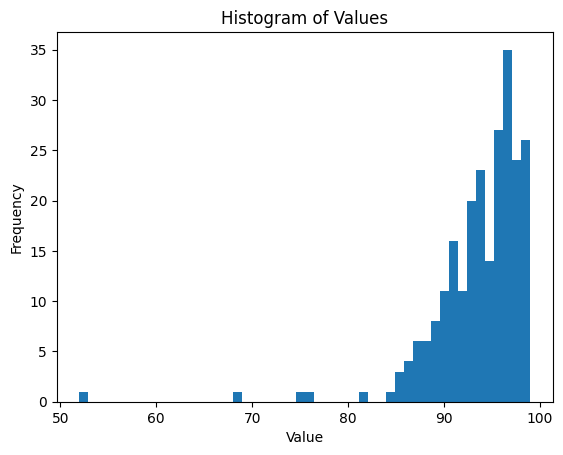

In [8]:
plot_histogram_of_chunk_length(length_resume_chunks, bins=50)()


TypeError: 'module' object is not callable

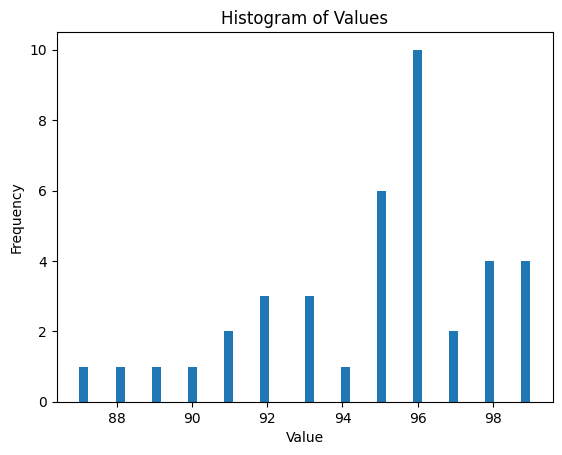

In [9]:
plot_histogram_of_chunk_length(length_jd_chunks, bins=50)()

In [10]:
import chromadb
from chromadb.utils.embedding_functions import create_langchain_embedding
from langchain_huggingface import HuggingFaceEmbeddings

langchain_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

ef = create_langchain_embedding(langchain_embeddings)
client = chromadb.PersistentClient(path="./chroma-data")
collection = client.get_or_create_collection(name="resume_collection", embedding_function=ef)

documents, ids, metadatas = [], [], []
for id, chunk in enumerate(resume_chunks):
    ids.append(str(id+1))
    documents.append(chunk.page_content)
    metadatas.append(chunk.metadata)

collection.add(ids=ids,documents=documents, metadatas=metadatas)


/home/harsha/code/bmw-tata-jv/civiliser/civiliser_venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding 

In [11]:
collection.query(
    query_texts=["Python", "SWE", "Accounts"],
    n_results=3,
    include=["metadatas", "documents"]
)

{'ids': [['50', '195', '224'], ['31', '30', '239'], ['153', '154', '152']],
 'distances': None,
 'metadatas': [[{'page': 0,
    'source': '../data/resumes/resume-software-engg.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-senior-python-dev.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-senior-python-dev.pdf'}],
  [{'page': 0, 'source': '../data/resumes/resume-software-engg.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-software-engg.pdf'},
   {'page': 1, 'source': '../data/resumes/resume-senior-python-dev.pdf'}],
  [{'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'}]],
 'embeddings': None,
 'documents': [['coursework while interning at IBM   SKILLS   Programming Languages: Python (Advanced), Java',
   'GIULIA GONZALEZ   PYTHON DEVELOPER   CONTACT   ggonzalez@email.com   (123) 456-7890   Detroit, M

### Prompts

In [13]:
# Possibility 1: Using Pipeline Prompt (https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.pipeline.PipelinePromptTemplate.html)
jd_docs[0].page_content

"Job brief   We are looking for an Accounts Payable Specialist to join our team and work with our accounting  department to oversee our organization's expenses.    Accounts Payable Specialist responsibilities include processing payments, verifying invoices and  performing account reconciliations as needed.    Ultimately, you will work with our accounting team to ensure our organization's expenditures are accurate  and our accounting practices are standardized across the organization.   Responsibilities    Charge expenses to accounts and cost centers and control petty cash spending    Verify vendor accounts, pay vendors and resolve purchase order, invoice or payment discrepancies    Issue purchase order amendments and stop payments    Monitor payroll expense claims, including salary advances and overtime payments    Reconcile account transactions with the general ledger    Perform recordkeeping and prepare financial reports    Keep informed of regulatory requirements and best practices 

In [20]:
from prompt import PROMPT
from langchain_core.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template(PROMPT)

'Extract top 3 technical skills required for a job from a given job description.\n\nInput: Job brief   We are looking for an Accounts Payable Specialist to join our team and work with our accounting  department to oversee our organization\'s expenses.    Accounts Payable Specialist responsibilities include processing payments, verifying invoices and  performing account reconciliations as needed.    Ultimately, you will work with our accounting team to ensure our organization\'s expenditures are accurate  and our accounting practices are standardized across the organization.   Responsibilities    Charge expenses to accounts and cost centers and control petty cash spending    Verify vendor accounts, pay vendors and resolve purchase order, invoice or payment discrepancies    Issue purchase order amendments and stop payments    Monitor payroll expense claims, including salary advances and overtime payments    Reconcile account transactions with the general ledger    Perform recordkeeping a

In [21]:
from dotenv import load_dotenv
load_dotenv()

OPEN_API_KEY = os.environ.get("OPENAI_API_KEY")

In [55]:
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain

llm = ChatOpenAI(model="gpt-4")
# llm_chain = LLMChain(llm=llm, prompt=prompt_template)

AIMessage(content='["Accounting and business management software", "Accounts payable principles", "Account reconciliation"]', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 697, 'total_tokens': 714, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bc1e55e5-8591-4769-98fe-e4390b617da6-0', usage_metadata={'input_tokens': 697, 'output_tokens': 17, 'total_tokens': 714, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [57]:
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

In [59]:
chain = prompt_template | llm | parser
results_chain = chain.invoke({"job_description": jd_docs[0].page_content})
string_to_list(results_chain)

['"Accounting and business management software"',
 '"Accounts payable principles"',
 '"Account reconciliation"']

In [46]:
llm_skills

'[CAD, Simulation Software, PCB Design]'

In [49]:
def string_to_list(s: str) -> list[str]:
    # Remove the first and last characters (the brackets)
    s = s[1:-1]
    
    # Split the string into a list using comma as delimiter
    # Also, remove any leading or trailing whitespaces from each item
    return [str(item.strip()) for item in s.split(',')]

string_to_list(llm_skills)

['CAD', 'Simulation Software', 'PCB Design']

In [60]:
collection.query(
    query_texts=string_to_list(results_chain),
    n_results=3,
    include=["metadatas", "documents"]
)

{'ids': [['189', '141', '137'], ['153', '158', '154'], ['154', '179', '153']],
 'distances': None,
 'metadatas': [[{'page': 0,
    'source': '../data/resumes/resume-accounts-payable.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-senior-accounting.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-senior-accounting.pdf'}],
  [{'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'}],
  [{'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-accounts-payable.pdf'}]],
 'embeddings': None,
 'documents': [['OF MARYLAND UNIVERSITY COLLEGE   Bachelor of Science in Business Administration, Accounting',
   'Financial Planning   EDUCATION   Bachelor of Science in Accounting   University of Ri

In [51]:
from langchain_core.output_parsers.base import BaseGenerationOutputParser, override

class ParseList(BaseGenerationOutputParser):
    @override
    def parse_result(self, s: str) -> list[str]:
        # Remove the first and last characters (the brackets)
        s = s[1:-1]
    
        # Split the string into a list using comma as delimiter
        # Also, remove any leading or trailing whitespaces from each item
        return [item.strip() for item in s.split(',')]

output_parser = ParseList()
output_parser.parse_result(llm_skills)

['CAD', 'Simulation Software', 'PCB Design']

In [52]:
chain = llm | output_parser

In [53]:
with open("../prompt_examples/jd_hardware_engg.txt", "r") as f:
    jd_hardware_engg = f.read()

chain.invoke({"job_description": jd_hardware_engg})

ValueError: Invalid input type <class 'dict'>. Must be a PromptValue, str, or list of BaseMessages.

In [62]:
import ollama
ollama.list()

ConnectError: [Errno 111] Connection refused